In [6]:
root="C:/github/RatDeconvolution"
path_package="C:/github/enan"

# Average Moving
***

In [2]:
import warnings
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import statsmodels.stats.multitest as sm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = 18
warnings.simplefilter('ignore')

In [3]:
def calc_z(res, drugs=list(), ctrl:str="Control"):
    df_z = pd.DataFrame(columns=res.columns.tolist())
    for drug in drugs:
        res_temp = res.loc[res.index.str.contains(drug),:]
        res_ctrl = res_temp.loc[res_temp.index.str.contains(ctrl),:]
        res_drug = res_temp.loc[~res_temp.index.str.contains(ctrl),:]
        
        mean = np.nanmean(res_ctrl.values,axis=0)
        std = np.nanstd(res_ctrl.values,axis=0)
        res_z = pd.DataFrame((res_drug.values - mean)/std)
        res_z.index = res_drug.index
        res_z.columns = res_drug.columns
        res_z = res_z.replace(np.inf,0)
        res_z = res_z.replace(-np.inf,0)
        res_z = res_z.fillna(0)
        if len(res.index)!=0:
            df_z = pd.concat([df_z, res_z],axis=0)
    return df_z

def load(target_compounds, median=True):
    # Deconvolution
    df_alt = pd.read_csv(f"{root}/data/tggate_biochemical_values.csv", index_col=0)
    df_alt = calc_z(df_alt.T, drugs=target_compounds, ctrl="ctrl")
    df_alt.index = [i.split("_rep")[0] for i in df_alt.index]
    df_alt = df_alt.loc[:,['ALT(IU/L)',]]
    df_alt.columns = ["ALT"]
    df_alt.index=[i.split(" h")[0] + " hr" for i in df_alt.index]
    if median:
        df_alt = df_alt.groupby(level=0,axis=0).median()

    df = pd.read_csv(f"{root}/result/tggate_result.csv", index_col=0)
    df = df.loc[(df.index.str.contains("High")) | (df.index.str.contains("Control")),:]
    df = df.loc[~(df.index.str.contains("day")),:]
    df_z = calc_z(df, drugs=target_compounds, ctrl="Control")
    if median:
        df_z = df_z.groupby(axis=0, level=0).mean()
    return df_z, df_alt

def calc_stat(df):
    lst_time = ["3 hr", "6 hr", "9 hr", "24 hr"]
    df_res = pd.DataFrame(index=df.columns, columns=lst_time)
    for time in lst_time:
        for target in df.columns.tolist():
            values = df.loc[df.index.str.contains(time),target].values.flatten()
            v_mean = np.mean(values)
            v_conf = stats.t.interval(alpha=0.95, df=len(values)-1, loc=v_mean, scale=stats.sem(values))
            df_res.loc[target, time]=[v_mean, v_conf[0], v_conf[1]]
    return df_res

In [4]:
target_compounds=[
    "naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril",
    "gefitinib","metformin","tiopronin","colchicine",
    "bortezomib","methylene dianiline","galactosamine","thioacetamide",
    "LPS","cycloheximide","tacrine","nitrofurazone",
    ]

clusters = [
    ["naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril","gefitinib","metformin","tiopronin",],
    ["colchicine","bortezomib","methylene dianiline","galactosamine","thioacetamide",],
    ["LPS","cycloheximide"],["tacrine","nitrofurazone"],
]

temp_lst = [
    "ALT",
    "Neu",
    "Mon",
    "CD4T",
    "CD8T",
]
lst_time = ["3 hr", "6 hr", "9 hr", "24 hr"]
colors=[
    ["firebrick", "salmon"],
    ["darkblue", "lightblue"],
    ["darkgreen","lightgreen"],
    ["darkviolet", "violet"],
]

In [5]:
df_d, df_b = load(target_compounds, median=False)
lst_df_stat=[]
for cluster in clusters:
    df_temp = pd.concat([df_d[df_d.index.str.contains(comp)] for comp in cluster], axis=0)
    df_stat = calc_stat(df_temp)
    df_temp = pd.concat([df_b[df_b.index.str.contains(comp)] for comp in cluster], axis=0)
    df_stat = pd.concat([df_stat, calc_stat(df_temp)], axis=0)
    lst_df_stat.append(df_stat)

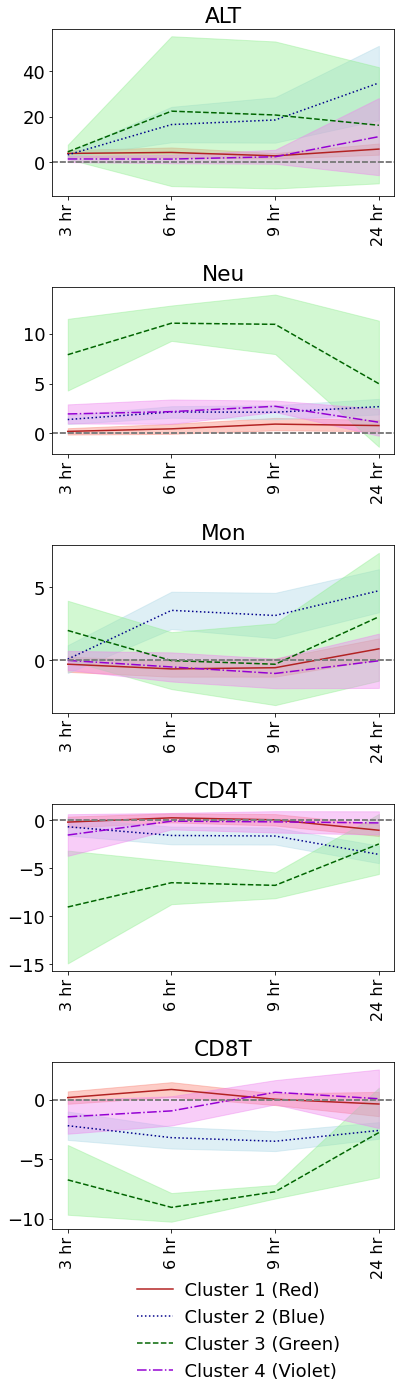

In [11]:
'''
lst_linestyle=["solid", "dotted", "dashed", "dashdot"]
fig = plt.figure(figsize=(30,4))
for x, temp in enumerate(temp_lst):
    ax=fig.add_subplot(1,5,x+1)
    legends=[]
    for v in range(4):   
        v_mean = [i[0] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_upper = [i[1] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_lower = [i[2] for i in lst_df_stat[v].loc[temp,:].tolist()]
        a, = ax.plot(range(4), v_mean, color=colors[v][0], linestyle=lst_linestyle[v])
        ax.axhline(0, color="grey", linestyle="dashed")
        ax.fill_between(range(4), v_lower, v_upper, color=colors[v][1], alpha=0.4)
        legends.append(a)
    ax.set_xticks(range(4))
    ax.set_xticklabels(lst_time, rotation=90, fontsize=16)
    #ax.set_xlim(-1,4)
    ax.set_title(temp)
legend = ax.legend(legends, [" Cluster 1 (Red)", " Cluster 2 (Blue)", " Cluster 3 (Green)", " Cluster 4 (Violet)"], bbox_to_anchor=(1, 0), loc='lower left',frameon=False, handletextpad=0, ncol=1, columnspacing=1)
plt.tight_layout()
plt.show()
'''

'''
lst_linestyle=["solid", "dotted", "dashed", "dashdot"]
fig = plt.figure(figsize=(15,8))
for x, temp in enumerate(temp_lst):
    ax=fig.add_subplot(2,3,x+1)
    legends=[]
    for v in range(4):   
        v_mean = [i[0] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_upper = [i[1] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_lower = [i[2] for i in lst_df_stat[v].loc[temp,:].tolist()]
        a, = ax.plot(range(4), v_mean, color=colors[v][0], linestyle=lst_linestyle[v])
        ax.axhline(0, color="grey", linestyle="dashed")
        ax.fill_between(range(4), v_lower, v_upper, color=colors[v][1], alpha=0.4)
        legends.append(a)
    ax.set_xticks(range(4))
    ax.set_xticklabels(lst_time, rotation=90, fontsize=16)
    #ax.set_xlim(-1,4)
    ax.set_title(temp)
ax = fig.add_subplot(2,3,6)
ax.axis("off")
legend = ax.legend(legends, ["  Cluster 1 (Red)", "  Cluster 2 (Blue)", "  Cluster 3 (Green)", "  Cluster 4 (Violet)"], bbox_to_anchor=(0, 0.2), loc='lower left',frameon=False, handletextpad=0, ncol=1, columnspacing=1)
plt.tight_layout()
plt.show()
'''

'''
lst_linestyle=["solid", "dotted", "dashed", "dashdot"]
fig = plt.figure(figsize=(10,12))
for x, temp in enumerate(temp_lst):
    ax=fig.add_subplot(3,2,x+1)
    legends=[]
    for v in range(4):   
        v_mean = [i[0] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_upper = [i[1] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_lower = [i[2] for i in lst_df_stat[v].loc[temp,:].tolist()]
        a, = ax.plot(range(4), v_mean, color=colors[v][0], linestyle=lst_linestyle[v])
        ax.axhline(0, color="grey", linestyle="dashed")
        ax.fill_between(range(4), v_lower, v_upper, color=colors[v][1], alpha=0.4)
        legends.append(a)
    ax.set_xticks(range(4))
    ax.set_xticklabels(lst_time, rotation=90, fontsize=16)
    #ax.set_xlim(-1,4)
    ax.set_title(temp)
ax = fig.add_subplot(3,2,6)
ax.axis("off")
legend = ax.legend(legends, ["  Cluster 1 (Red)", "  Cluster 2 (Blue)", "  Cluster 3 (Green)", "  Cluster 4 (Violet)"], bbox_to_anchor=(0, 0.2), loc='lower left',frameon=False, handletextpad=0, ncol=1, columnspacing=1)
plt.tight_layout()
#plt.savefig(f"{root}/figures/fig5a.png", dpi=300)
plt.show()
'''

lst_linestyle=["solid", "dotted", "dashed", "dashdot"]
fig = plt.figure(figsize=(6,20))
for x, temp in enumerate(temp_lst):
    ax=fig.add_subplot(5,1,x+1)
    legends=[]
    for v in range(4):   
        v_mean = [i[0] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_upper = [i[1] for i in lst_df_stat[v].loc[temp,:].tolist()]
        v_lower = [i[2] for i in lst_df_stat[v].loc[temp,:].tolist()]
        a, = ax.plot(range(4), v_mean, color=colors[v][0], linestyle=lst_linestyle[v])
        ax.axhline(0, color="grey", linestyle="dashed")
        ax.fill_between(range(4), v_lower, v_upper, color=colors[v][1], alpha=0.4)
        legends.append(a)
    ax.set_xticks(range(4))
    ax.set_xticklabels(lst_time, rotation=90, fontsize=16)
    #ax.set_xlim(-1,4)
    ax.set_title(temp)
legend = ax.legend(legends, ["  Cluster 1 (Red)", "  Cluster 2 (Blue)", "  Cluster 3 (Green)", "  Cluster 4 (Violet)"], bbox_to_anchor=(0.2, -1), loc='lower left',frameon=False, handletextpad=0, ncol=1, columnspacing=1)
plt.tight_layout()
#plt.savefig(f"{root}/figures/fig5a.png", dpi=300)
plt.show()

# ssGSEA Analysis
***

## Preparation of rat gene ontology data

In [ ]:
filein = f"{root}/data/rgd.gaf" # from the web site: www.geneontology.org
datafile = f'{root}/data/220801_go.owl' # from the web site: www.geneontology.org
depth=5 # gene ontology depth for enrichment analysis

In [ ]:
import csv
from collections import deque, defaultdict

import numpy as np
import pandas as pd


import owlready2
from tqdm import tqdm

In [ ]:
class OntologyStructure:
    def __init__(self, datafile, root_term:str):
        """
        constructor
        datafile : str, the url of ontology file
        """
        
        # load datafile
        self.onto = owlready2.get_ontology(datafile).load() # load ontology file (DL from https://www.ebi.ac.uk/efo/)
        print(datafile,"was loaded.")
        
        # determine the roots
        roots = []
        for efo in self.onto.classes(): # EFO0000001 is the root
            if root_term in str(efo):
                roots.append(efo)
        if len(roots) == 0:
            print('the designated root term couldnt be found')
            for efo in self.onto.classed():
                if 'EFO0000001' in str(efo):
                    roots.append(efo)

        # select the first root CAUTION : this must be changed if you use an ontology structure which have multiple roots
        self.root = roots[0] 
        print(self.root, "was determined as root.")
        # with BFS, determine the depth of each GO
        self.min_d = self.__BFS() # 幅優先探索をやってる
        print("Graph structure was obtained.")
        
        self.string_hash = self.__create_string_hash()
        print("String hashtable was created.")
 
    def __BFS(self):
        """
        breadth-first search function
        
        the function to determine the depth of each term
        """
        Q = deque([self.root])
        inf_value = lambda : float('inf')
        min_d = defaultdict(inf_value) # defaultdictでエラーしたらinfを返すようにしている. つまり届かないところ
        min_d[self.root] = 0 # rootの深さは0と定義
        while len(Q)>0:
            v = Q.pop()
            for v1 in self.onto.get_children_of(v): # vの子v1をループ
                if min_d[v1]>10**27: # infより大きい場合. Noneでもいいような. 要するにまだmin_dが定義されていないvの子供が現れた時の判定
                    min_d[v1] = min_d[v] + 1 # min_dがない子供が現れたらvの深さに1段階加えて更新する
                    Q.appendleft(v1) # Qは探索すべきものなので, 新たな階層の探索のために追加する
        return min_d # 木構造を返す: タームを入れるとその深さを返すもの

    def __create_string_hash(self):
        """
        string hash function
        
        create the hashtable to get the class instance corresponding to the given string
        """
        
        string_hash = defaultdict(str)
        for key in self.min_d:
            string_hash[str(key)] = key
        return string_hash

    def get_num(self, depth):
        """
        getting the number of ontology term in a specific level
        depth : int
        """
        count = 0
        for key in self.min_d:
            if self.min_d[key]==depth:
                count+=1
        return count
    
    def get_term(self, depth):
        """
        getting the term in the specific level
        depth :  int
        """
        res = []
        term = []
        for key in self.min_d:
            if self.min_d[key]==depth:
                res.append(str(key))
                term.append(str(key.label[0]))
        return res,term
    
    def get_downstream_ID(self):
        max_depth = max(list(self.min_d.values()))
        print('max depth :',max_depth)
        total_res = []
        total_term = []
        for i in range(1,max_depth+1):
            tmp_res = []
            tmp_term = []
            for key in self.min_d:
                if self.min_d[key]==i:
                    tmp_res.append(str(key))
                    tmp_term.append(str(key.label[0]))
            
            for t in tmp_res:
                total_res.append(t)
            for s in tmp_term:
                total_term.append(s)
        return total_res, total_term
    
    def get_upstream(self, go, depth):
        """
        getting the upstream GO in a specific level
        
        go : GO class instance
        depth : int
        """
        if self.min_d[go]<2:
            return set()
        if self.min_d[go]==2:
            return set([go])
        
        up = set()

        Q = deque([go])
        while len(Q)>0:
            v = Q.pop()
            try:
                for v1 in self.onto.get_parents_of(v):
                    if self.min_d[v1]==depth:
                        up.add(v1)
                    else:
                        Q.appendleft(v1)
            except:
                pass
            
        return up
    
    def str2go(self, string):
        """
        str to GO class instance
        """
        return self.string_hash[string]

    def go2str(self, go):
        """
        GO class instance to str
        """
        return str(go)

    def get_depth(self, go):
        """
        get the depth of GO
        """
        return self.min_d[go]
        
    def get_term(self, depth):
        """
        getting the term in the specific level
        depth :  int
        """
        res = []
        term = []
        for key in self.min_d:
            if self.min_d[key]==depth:
                res.append(str(key))
                term.append(str(key.label[0]))
        return res,term
    
    def get_downstream(self, go):
        """
        getting the deepest downstream go terms
        go : GO class instancce
        """
        res = []
        Q = deque(self.onto.get_children_of(go))
        if len(Q)==0:
            return [go]
        
        while len(Q)>0:
            v = Q.pop()
            res.append(v)
            v_child = self.onto.get_children_of(v)
            if len(v_child)==0:
                pass
            else:
                for v1 in v_child:
                    Q.appendleft(v1)
        res = list(set(res))
        return res     

def load_go(gene_dict=dict()):
    terms = []
    members = []
    for key in gene_dict.keys():
        terms.append(key)
        members.append(gene_dict[key])
    return terms, members

def create_dict(datafile='', gene_dict=dict(), depth:int=4):
    # load go.owl file
    dat = OntologyStructure(datafile, 'obo.GO_0008150') #GO_0008150 : Biological Process
    res, term = dat.get_term(depth)
    print('Indicated depth GO terms : {}'.format(len(res)))
    corresp_res = [dat.get_downstream(dat.str2go(i)) for i in tqdm(res)]
    corresp_res = [[str(v).replace('obo.GO_', 'GO:') for v in i] for i in corresp_res]

    # load gene file
    terms, members = load_go(gene_dict=gene_dict)
    #terms = [i.split('(')[1].split(')')[0] for i in terms]
    go_dict = dict(zip(terms, members))
    
    # create dict
    res_dict=dict()
    goperterm=[]
    for root, i, t in zip(res,corresp_res, term):
        res_temp = set()
        for v in i:
            genes_temp=go_dict.get(v, 'no')
            if genes_temp=='no':
                pass
            else:
                res_temp = res_temp or genes_temp
        if len(res_temp)>0:
            res_dict[root.replace('obo.GO_','GO:')+'_'+t]=res_temp
            goperterm.append(len(res_temp))

    print('No. of GO terms : {}'.format(len(res_dict)))
    print('No. of genes / term : {}'.format(np.mean(goperterm)))

    return res_dict

def extract(sentence):
    res = []
    temp1 = sentence.split("RGD\t")
    flag=False
    for i in temp1:
        temp2 = i.split("\t")
        if len(temp2)>5:
            symbol = temp2[1]
            term = temp2[3]
            if "GO:" in term:
                res.append([symbol, term])
                flag=True
    temp1 = sentence.split("UniProtKB\t")
    for i in temp1:
        temp2 = i.split("\t")
        if len(temp2)>5:
            symbol = temp2[1]
            term = temp2[3]
            if "GO:" in term:
                res.append([symbol, term])
                flag=True
    if flag:
        return res, []
    else:
        return res, [sentence]

In [ ]:
with open(filein, encoding='utf-8', newline='') as f:
    reader = csv.reader(f)
    res = [cols for cols in reader]

res = res[39:]
res_open=[]
res_error1=[]
res_error2=[]
for i in res:
    if type(i)==str:
        res_temp, error = extract(i)
        res_open += res_temp
        res_error1 += error
    elif len(i)==1:
        res_temp, error = extract(i[0])
        res_open += res_temp
        res_error1 += error
    else:
        for v in i:
            if type(v)==str:
                res_temp, error = extract(v)
                res_open += res_temp
                res_error2 += error
            else:
                res_temp, error = extract(v[0])
                res_open += res_temp
                res_error2 += error
e2_go = []
for i in res_error2:
    if "GO" in i:
        e2_go.append(i)

In [ ]:
e2_go[:10]

['regulates(GO:0006366)\t',
 '8-sialyltransferase 5\t\tgene\ttaxon:10116\t20220421\tGOC\t\t',
 '8-sialyltransferase 5\t\tgene\ttaxon:10116\t20220421\tGOC\t\t',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\tpart_of(UBERON:0002421)\t',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\tpart_of(UBERON:0002421)\t',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\tpart_of(GO:0098978)',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\tpart_of(GO:0098978)',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\toccurs_in(GO:0098978)',
 ' ankyrin repeat and coiled-coil containing 1\t\tgene\ttaxon:10116\t20180711\tSynGO\toccurs_in(GO:0098978)',
 ' member 2\t\tgene\ttaxon:10116\t20050726\tRGD\tnegatively_regulates(GO:0008283)\t']

In [ ]:
res_dict = dict()
term_set = set()
for gene, term in res_open:
    if not term in term_set:
        term_set.add(term)
        res_dict[term]=set([gene])
    else:
        res_dict[term].add(gene)

In [ ]:
res = create_dict(datafile=datafile, gene_dict=res_dict, depth=depth)

C:/github/2023/RatDeconvolution/data/220801_go.owl was loaded.
obo.GO_0008150 was determined as root.
Graph structure was obtained.
String hashtable was created.
Indicated depth GO terms : 6712


100%|██████████| 6712/6712 [00:00<00:00, 8434.59it/s] 


No. of GO terms : 3447
No. of genes / term : 7.559036843632144


In [ ]:
pd.to_pickle(res, f"{root}/result/go_rat_depth5.pickle")

## ssGSEA

In [ ]:
# import
import sys
import warnings

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import copy
import codecs

sys.path.append("C:/github/enan")
from enan import ssgsea

warnings.simplefilter('ignore')

In [ ]:
def annotation_sample(df, df_b):
    temp = df_b.loc[df.columns.tolist()]
    name = temp["COMPOUND_NAME"].tolist()
    dose = temp["DOSE_LEVEL"].tolist()
    time = temp["SACRIFICE_PERIOD"].tolist()
    ind = [f"{i}_{j}_{k}" for i, j, k in zip(name, dose, time)]
    return ind

def load_transcriptome(target_compounds):
    # load transcriptome
    df_target = pd.read_csv(f"{root}/data/tggate_transcriptome.csv",index_col=0)
    df_sample = pd.read_csv(f"{root}/data/tggate_sample_information.csv",index_col=0)
    df_target.columns=[str(i) for i in df_target.columns]
    df_sample.index=[str(i) for i in df_sample.index]
    df_target.columns = annotation_sample(df_target, df_sample)
    target_lst = [
        f'{compound}_{conc}_{time}'
        for compound in target_compounds 
        for conc in ["High", "Control"]
        for time in ["3 hr", "6 hr", "9 hr", "24 hr"]
    ]
    df_target=df_target.loc[:,target_lst]
    return df_target

def calc_ssGSEA(df, depth=5, limit=10):
    # load
    set_depth = pd.read_pickle(f"{root}/result/go_rat_depth{str(depth)}.pickle")
    ref = dict()
    set_whole=set()
    for i in set_depth.keys():
        temp = set_depth[i]
        if len(temp)>limit-1:
            ref[i]=temp
            set_whole = set_whole|set_depth[i]
    print(f"ref length: {len(ref)}")
    print(f"whole genes: {len(set_whole)}")

    dat = ssgsea.ssGSEA()
    dat.fit(ref)
    dat.set_whole(set_whole)
    res = dat.calc(df, method="kuiper")
    return res

In [ ]:
target_compounds=[
    "naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril",
    "gefitinib","metformin","tiopronin","colchicine",
    "bortezomib","methylene dianiline","galactosamine","thioacetamide",
    "LPS","cycloheximide","tacrine","nitrofurazone",
    ]


In [ ]:
df = load_transcriptome(target_compounds)
col = df.columns.tolist()
df.columns=range(len(df.columns))

In [ ]:
res = calc_ssGSEA(df, depth=5)
res.columns=col

ref length: 584
whole genes: 8098
Kuiper method


100%|██████████| 383/383 [07:04<00:00,  1.11s/it]


In [ ]:
res.to_csv(f"{root}/result/res_depth5_kuiper.csv")

## Analysis/Visualization

In [7]:
import copy
import warnings

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.stats.multitest as sm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = 16
warnings.simplefilter('ignore')

In [8]:
def calc_z(res, drugs=list(), ctrl:str="Control"):
    df_z = pd.DataFrame(columns=res.columns.tolist())
    for drug in drugs:
        res_temp = res.loc[res.index.str.contains(drug),:]
        res_ctrl = res_temp.loc[res_temp.index.str.contains(ctrl),:]
        res_drug = res_temp.loc[~res_temp.index.str.contains(ctrl),:]
        
        mean = np.nanmean(res_ctrl.values,axis=0)
        std = np.nanstd(res_ctrl.values,axis=0)
        res_z = pd.DataFrame((res_drug.values - mean)/std)
        res_z.index = res_drug.index
        res_z.columns = res_drug.columns
        res_z = res_z.replace(np.inf,0)
        res_z = res_z.replace(-np.inf,0)
        res_z = res_z.fillna(0)
        if len(res.index)!=0:
            df_z = pd.concat([df_z, res_z],axis=0)
    return df_z

def test_cluster(res, cluster, lst_clusters):
    df_res=pd.DataFrame(index=["cluster_max", "pval_max", "fc_max", "cluster_min", "pval_min", "fc_min"])
    lst_df_cl = [res.loc[:,lst_clusters[cluster[i]]] for i in range(4)]
    for go in lst_df_cl[0].index.tolist():
        lst_m=[i.loc[go,:].mean() for i in lst_df_cl]
        lst_m=sorted(enumerate(lst_m), key=lambda x:x[1], reverse=True)
        pval_max=stats.ttest_ind(lst_df_cl[lst_m[0][0]].loc[go,:], lst_df_cl[lst_m[1][0]].loc[go,:],equal_var=False)[1]
        fc_max=lst_m[0][1]/lst_m[1][1]
        pval_min=stats.ttest_ind(lst_df_cl[lst_m[2][0]].loc[go,:], lst_df_cl[lst_m[3][0]].loc[go,:],equal_var=False)[1]
        fc_min=lst_m[3][1]/lst_m[2][1]        
        df_res[go]=[
            lst_m[0][0],
            pval_max,
            fc_max,
            lst_m[3][0],
            pval_min,
            fc_min,]
    return df_res

def plot_go_violin(df, lst_all, term:str="", ax=""):
    df_temp = pd.DataFrame()
    names = [
        "Ctrl", 
        "Cluster1/ 3hr", "Cluster1/ 6hr", "Cluster1/ 9hr", "Cluster1/ 24hr", 
        "Cluster2/ 3hr", "Cluster2/ 6hr", "Cluster2/ 9hr", "Cluster2/ 24hr",
        "Cluster3/ 3hr", "Cluster3/ 6hr", "Cluster3/ 9hr", "Cluster3/ 24hr",
        "Cluster4/ 3hr", "Cluster4/ 6hr", "Cluster4/ 9hr", "Cluster4/ 24hr",]
    colors=[
        ["salmon"]*4,
        ["lightblue"]*4,
        ["lightgreen"]*4,
        ["violet"]*4,
    ]
    colors=[list(i)[0] for i in np.array(colors).reshape(-1,1)]
    for i in lst_all:
        temp = df.loc[term, i].values.flatten()
        df_temp = pd.concat([df_temp, pd.DataFrame(temp)], axis=1)
    df_temp.columns=names
    sns.violinplot(x='variable', y='value', data=df_temp.melt(), dodge=True,
                jitter=True, color='black', palette=["grey"]+list(colors), ax=ax)
    
    ax.axhline(y=df_temp["Ctrl"].median(), color="grey", linestyle="dashed")
    ax.set_xticks(range(17))
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.set_ylabel('ssGSEA Score', fontsize=16)
    ax.set_xlim(-1,17)
    str_go, str_name = term.split("_")
    ax.set_title(f"{str_go}\n{str_name}\n", fontsize=16)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.grid(False)

def inspect(df_res_all, cluster_number, max=True):
    if max:
        pval_name="pval_max"
        cluster_name="cluster_max"
    else:
        pval_name="pval_min"
        cluster_name="cluster_min"
    df_temp = df_res_all[df_res_all[cluster_name]==cluster_number]
    return df_temp.sort_values(by=[pval_name])

In [9]:
clusters = [
    ["naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril","gefitinib","metformin","tiopronin",],
    ["colchicine","bortezomib","methylene dianiline","galactosamine","thioacetamide",],
    ["LPS","cycloheximide"],["tacrine","nitrofurazone"],
]
depth=5


In [10]:
res = pd.read_csv(f"{root}/result/res_depth5_kuiper.csv", index_col=0)
res.columns = [i.split(".")[0] for i in res.columns]
res=res.dropna()

In [11]:
# t test
lst_clusters = [[f"{comp}_High_{time}" for comp in cluster] for time in ["3 hr", "6 hr", "9 hr", "24 hr"] for cluster in clusters]
df_res_3h=test_cluster(res, [0,1,2,3], lst_clusters)
df_res_6h=test_cluster(res, [4,5,6,7], lst_clusters)
df_res_9h=test_cluster(res, [8,9,10,11], lst_clusters)
df_res_24h=test_cluster(res, [12,13,14,15], lst_clusters)
df_res_3h.columns=[f"{i}_3h" for i in df_res_3h.columns.tolist()]
df_res_6h.columns=[f"{i}_6h" for i in df_res_6h.columns.tolist()]
df_res_9h.columns=[f"{i}_9h" for i in df_res_9h.columns.tolist()]
df_res_24h.columns=[f"{i}_24h" for i in df_res_24h.columns.tolist()]
df_res_all = pd.concat([df_res_3h, df_res_6h, df_res_9h, df_res_24h], axis=1).T

In [12]:
# set labels
lst_control = [f"{comp}_Control_{time}" for time in ["3 hr", "6 hr", "9 hr", "24 hr"] for cluster in clusters for comp in cluster]
lst_clusters = [[f"{comp}_High_{time}" for comp in cluster] for cluster in clusters for time in ["3 hr", "6 hr", "9 hr", "24 hr"]]
lst_all = [lst_control]
lst_all.extend(lst_clusters)
labels = []
target_lst=[]
for i, lst in enumerate(lst_all):
    labels+=[i]*len(lst)
    target_lst.extend(lst)
res_temp = copy.deepcopy(res)
res_temp = res_temp.loc[:,target_lst]

In [13]:
# multiple test
df_res_all["qval_max"]=sm.fdrcorrection(df_res_all["pval_max"].values, method='indep')[1]
df_res_all["qval_min"]=sm.fdrcorrection(df_res_all["pval_min"].values, method='indep')[1]

### Cluster 1

In [9]:
inspect(df_res_all, 0, max=True).head(5)

,cluster_max,pval_max,fc_max,cluster_min,pval_min,fc_min,qval_max,qval_min
GO:0032965_regulation of collagen biosynthetic process_9h,0.0,0.000015,1.085868,2.0,0.728974,0.973586,0.003325,0.925848
GO:0071479_cellular response to ionizing radiation_3h,0.0,0.000685,1.099570,3.0,0.504640,0.970248,0.036097,0.808535
GO:0010332_response to gamma radiation_3h,0.0,0.000685,1.099570,3.0,0.504640,0.970248,0.036097,0.808535
GO:0032965_regulation of collagen biosynthetic process_6h,0.0,0.000752,1.085222,1.0,0.046274,0.931078,0.036489,0.264680
GO:0045199_maintenance of epithelial cell apical/basal polarity_6h,0.0,0.000790,1.189930,2.0,0.234968,0.921254,0.037550,0.586916


In [10]:
inspect(df_res_all, 0, max=False).head(5)

,cluster_max,pval_max,fc_max,cluster_min,pval_min,fc_min,qval_max,qval_min
GO:0014037_Schwann cell differentiation_6h,1.0,0.193199,1.109177,0.0,0.000182,0.819779,0.656637,0.011975
GO:0051348_negative regulation of transferase activity_6h,1.0,0.147529,1.192258,0.0,0.002071,0.919443,0.584095,0.050231
GO:0043549_regulation of kinase activity_6h,1.0,0.147529,1.192258,0.0,0.002071,0.919443,0.584095,0.050231
GO:0098760_response to interleukin-7_6h,1.0,0.954258,1.001389,0.0,0.002425,0.972651,0.993211,0.054311
GO:0071391_cellular response to estrogen stimulus_6h,2.0,0.000539,1.199709,0.0,0.002864,0.861141,0.033013,0.059113


### Cluster 2

In [11]:
inspect(df_res_all, 1, max=True).head(5)

,cluster_max,pval_max,fc_max,cluster_min,pval_min,fc_min,qval_max,qval_min
GO:0048660_regulation of smooth muscle cell proliferation_24h,1.0,0.000887,1.172714,3.0,0.146633,0.863022,0.039243,0.467584
GO:0051028_mRNA transport_6h,1.0,0.001091,1.089962,3.0,0.947578,0.996333,0.043304,0.993527
GO:0030539_male genitalia development_24h,1.0,0.007390,1.110392,3.0,0.373230,0.944262,0.133372,0.712197
GO:1900407_regulation of cellular response to oxidative stress_24h,1.0,0.008265,1.106729,3.0,0.010420,0.867985,0.139424,0.125686
GO:1902883_negative regulation of response to oxidative stress_24h,1.0,0.008265,1.106729,3.0,0.010420,0.867985,0.139424,0.125686


In [12]:
inspect(df_res_all, 1, max=False).head(5)

,cluster_max,pval_max,fc_max,cluster_min,pval_min,fc_min,qval_max,qval_min
GO:0032400_melanosome localization_6h,3.0,0.120214,1.057928,1.0,0.000178,0.892061,0.540215,0.011975
GO:0032402_melanosome transport_6h,3.0,0.120214,1.057928,1.0,0.000178,0.892061,0.540215,0.011975
GO:0036295_cellular response to increased oxygen levels_24h,2.0,0.690764,1.054939,1.0,0.000185,0.803719,0.956042,0.011975
GO:0030593_neutrophil chemotaxis_3h,3.0,0.628613,1.064829,1.0,0.000561,0.858542,0.935685,0.022662
GO:0035855_megakaryocyte development_24h,3.0,0.232657,1.090952,1.0,0.000662,0.909592,0.681618,0.024855


### Cluster 3

In [13]:
inspect(df_res_all, 2, max=True).head(5)

,cluster_max,pval_max,fc_max,cluster_min,pval_min,fc_min,qval_max,qval_min
GO:0060337_type I interferon signaling pathway_9h,2.0,3.435963e-11,1.218364,3.0,0.585458,0.979219,7.998922e-08,0.868671
GO:0051092_positive regulation of NF-kappaB transcription factor activity_6h,2.0,2.322300e-08,1.211200,3.0,0.316419,0.950974,2.703157e-05,0.669657
GO:0070498_interleukin-1-mediated signaling pathway_3h,2.0,5.769805e-07,1.239766,3.0,0.008202,0.880012,3.885533e-04,0.114309
GO:0080164_regulation of nitric oxide metabolic process_9h,2.0,6.676174e-07,1.297882,3.0,0.137894,0.977225,3.885533e-04,0.450199
GO:0097396_response to interleukin-17_6h,2.0,1.419429e-06,1.413684,3.0,0.000511,0.828829,6.417110e-04,0.022457


In [14]:
inspect(df_res_all, 2, max=False).head(5)

,cluster_max,pval_max,fc_max,cluster_min,pval_min,fc_min,qval_max,qval_min
GO:0048536_spleen development_9h,3.0,0.853608,1.015860,2.0,2.904687e-10,0.561775,0.984249,6.762110e-07
GO:0010165_response to X-ray_6h,3.0,0.285811,1.056409,2.0,2.170776e-09,0.660894,0.721657,2.526783e-06
GO:0060491_regulation of cell projection assembly_3h,3.0,0.387464,1.034333,2.0,5.032519e-07,0.757771,0.808218,2.928926e-04
GO:0001838_embryonic epithelial tube formation_9h,3.0,0.131403,1.067959,2.0,4.909958e-06,0.802904,0.560268,1.905064e-03
GO:0070670_response to interleukin-4_6h,3.0,0.744154,1.006961,2.0,8.830825e-06,0.828222,0.970123,2.473601e-03


### Cluster 4

In [15]:
inspect(df_res_all, 3, max=True).head(5)

,cluster_max,pval_max,fc_max,cluster_min,pval_min,fc_min,qval_max,qval_min
GO:0099560_synaptic membrane adhesion_3h,3.0,0.000075,1.199131,2.0,0.066309,0.842240,0.009827,0.316326
GO:0032543_mitochondrial translation_6h,3.0,0.000085,1.044956,1.0,0.034537,0.952846,0.009827,0.230392
GO:0070371_ERK1 and ERK2 cascade_24h,3.0,0.000118,1.292538,1.0,0.606609,0.956742,0.011920,0.883657
GO:0034394_protein localization to cell surface_3h,3.0,0.000153,1.165181,2.0,0.347921,0.948514,0.014270,0.688741
GO:0001921_positive regulation of receptor recycling_3h,3.0,0.000189,1.143570,2.0,0.273545,0.956571,0.015953,0.629243


In [16]:
inspect(df_res_all, 3, max=False).head(5)

,cluster_max,pval_max,fc_max,cluster_min,pval_min,fc_min,qval_max,qval_min
GO:0070527_platelet aggregation_3h,1.0,0.838526,1.005227,3.0,7.776319e-08,0.904328,0.984114,0.000060
GO:0060716_labyrinthine layer blood vessel development_6h,1.0,0.023391,1.188855,3.0,4.324725e-06,0.797027,0.237917,0.001905
GO:0021527_spinal cord association neuron differentiation_24h,2.0,0.541337,1.040562,3.0,9.562889e-06,0.717716,0.905013,0.002474
GO:0050847_progesterone receptor signaling pathway_9h,1.0,0.270688,1.055397,3.0,1.655264e-05,0.791518,0.704161,0.003207
GO:0045214_sarcomere organization_24h,1.0,0.022741,1.112247,3.0,2.127468e-05,0.745136,0.236344,0.003207


## Visualization

### up direction

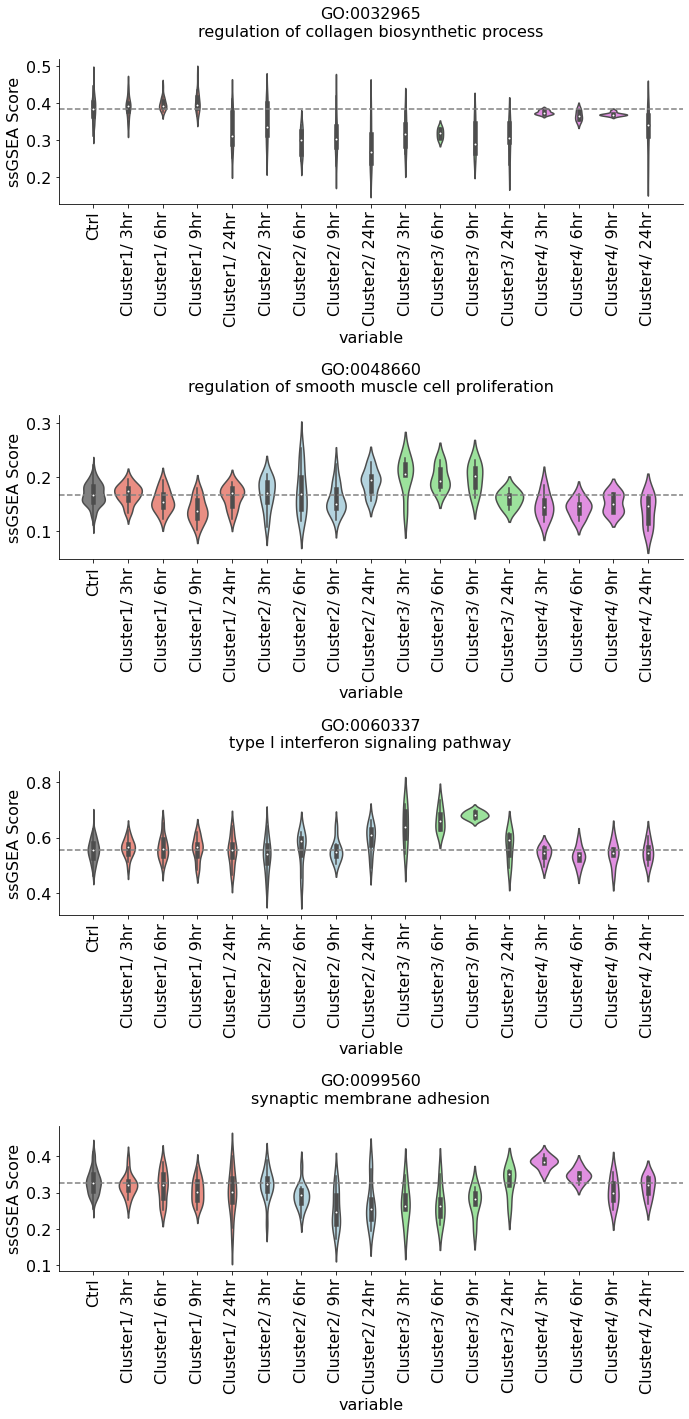

In [17]:
fig = plt.figure(figsize=(10,20))
for v in range(4):
    ax=fig.add_subplot(4,1,v+1)
    plot_go_violin(res_temp, lst_all=lst_all, term=inspect(df_res_all, v, max=True).index[0].rsplit("_", 1)[0], ax=ax)
plt.tight_layout()
plt.show()    

### down direction

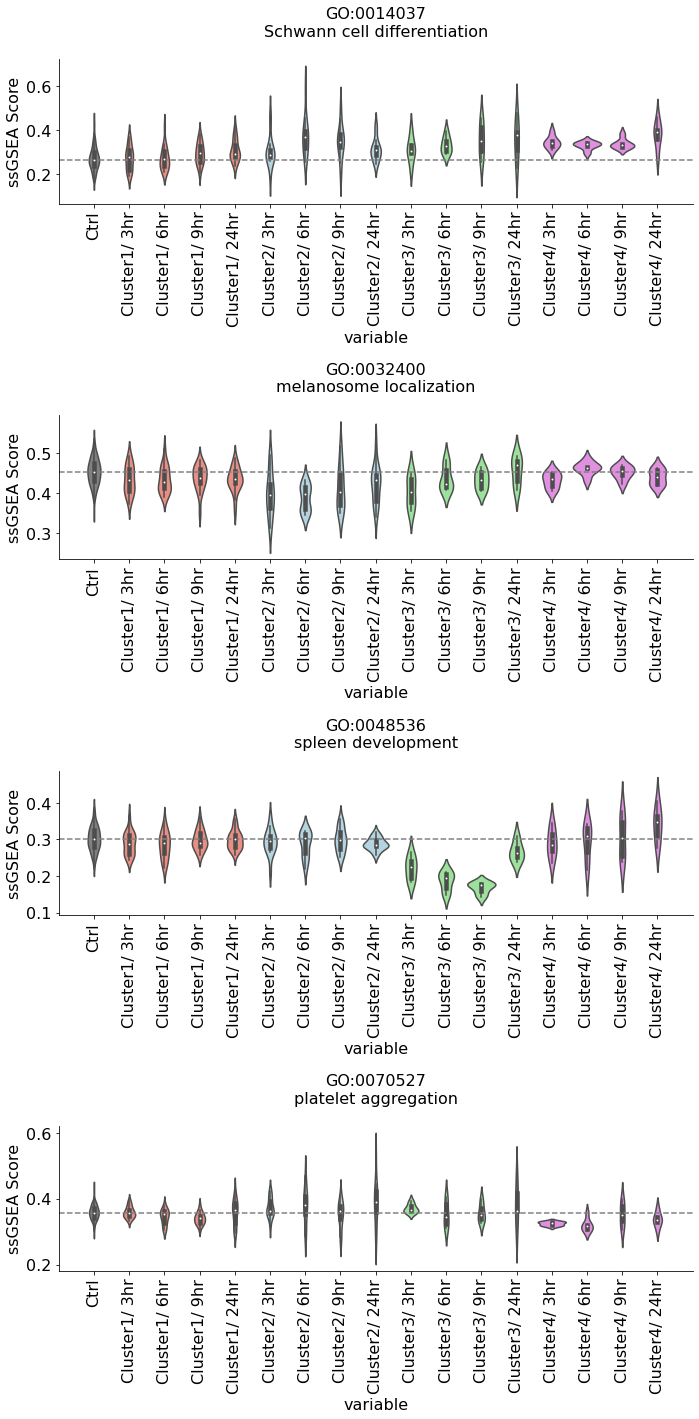

In [18]:
fig = plt.figure(figsize=(10,20))
for v in range(4):
    ax=fig.add_subplot(4,1,v+1)
    plot_go_violin(res_temp, lst_all=lst_all, term=inspect(df_res_all, v, max=False).index[0].rsplit("_", 1)[0], ax=ax)
plt.tight_layout()
plt.show()    

#### focused term

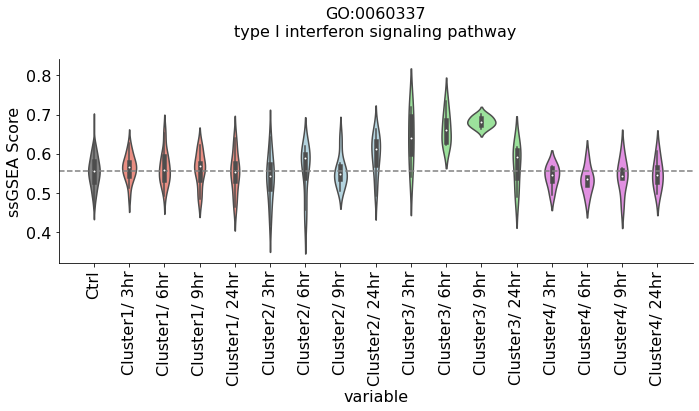

In [15]:
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
term="GO:0060337_type I interferon signaling pathway"
plot_go_violin(res_temp, lst_all=lst_all, term=term, ax=ax)
plt.tight_layout()
#plt.savefig(f"{root}/figures/fig5b.png", dpi=300)
plt.show()

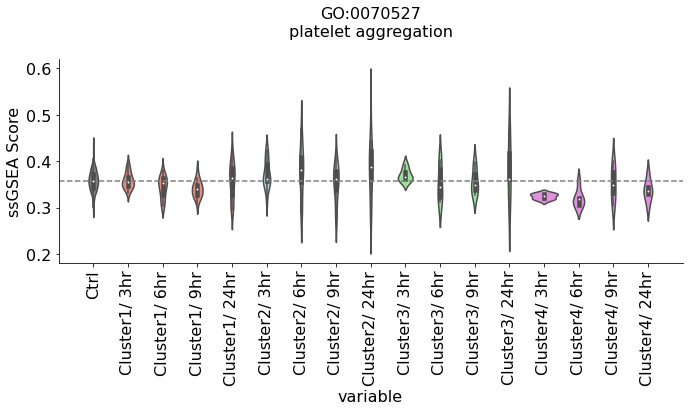

In [13]:
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
term="GO:0070527_platelet aggregation"
plot_go_violin(res_temp, lst_all=lst_all, term=term, ax=ax)
plt.tight_layout()
#plt.savefig(f"{root}/figures/fig5c.png", dpi=300)
plt.show()